In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scvi
import os
sc.set_figure_params(figsize=(4, 4))


num_of_clusters = 8

ToolName = 'scvi-tools' 
DatasetName = 'zheng-8'
Data_path = '../../dataset/{}-filtered/10X/'.format(DatasetName)
save_path = '../../results/{}/{}/'.format(DatasetName, ToolName)


if not os.path.exists(save_path):
    os.makedirs(save_path)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0


## Loading and preparing data

In [2]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)
adata

AnnData object with n_obs × n_vars = 3934 × 12990
    var: 'gene_ids'

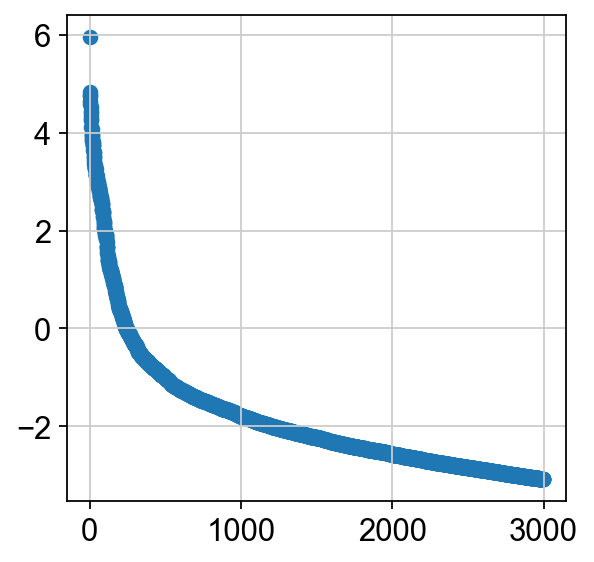

In [3]:
matrix = adata.X
# from sparse matrix to dense matrix
matrix = matrix.todense()
# find the most variable features (columns) of the matrix sorted by variance
variances = np.sort(-np.var(matrix, axis=0))
sorted_array = [np.log(-i) for i in variances.T][:3000]
# plot the variance of the features
plt.scatter([i for i in range(len(sorted_array))], sorted_array)

In [4]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

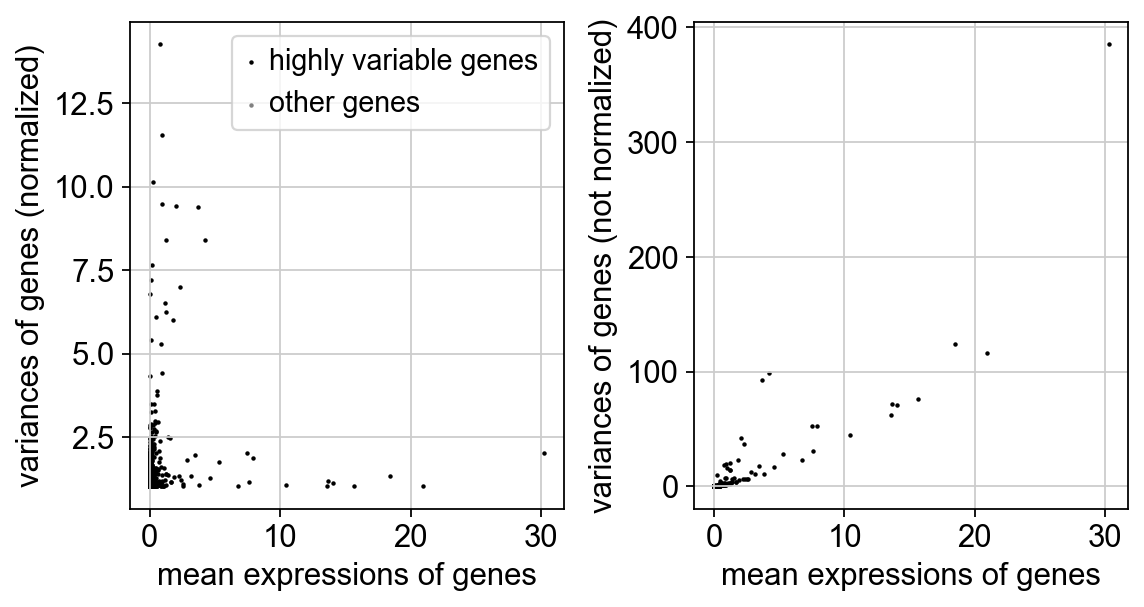

In [5]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)

In [6]:
sc.pp.scale(adata, max_value=10)

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
)

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [8]:
if os.path.exists('./models/{}/'.format(DatasetName)):
    model = scvi.model.SCVI.load('./models/{}/'.format(DatasetName), adata=adata, use_gpu=True)
else:
    model = scvi.model.SCVI(adata)
    model.train(use_gpu=False)
    model.save('./models/{}/'.format(DatasetName))
    
model

INFO     File ./models/zheng-8/model.pt already downloaded                                                         


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

## Obtaining model outputs

In [9]:
latent = model.get_latent_representation()

In [10]:
adata.obsm["X_scVI"] = latent
adata_subset = adata

In [11]:
latent_subset = model.get_latent_representation(adata_subset)

In [12]:
denoised = model.get_normalized_expression(adata_subset)
denoised.iloc[:5, :5]

,HES4,ISG15,AGRN,C1orf159,TNFRSF18
ACGGAGGACCGAAT,0.000005,0.000625,0.000111,0.000083,0.000014
GCAGCGTGCCGAAT,0.000021,0.000197,0.000060,0.000050,0.000003
GATTTAGAGTGTAC,0.000037,0.000334,0.000013,0.000049,0.000053
TCAGTGGAGTTCAG,0.000007,0.000146,0.000014,0.000072,0.000004
GCCTCATGCGGGAA,0.000002,0.000373,0.000004,0.000030,0.000010


Let's store the normalized values back in the anndata.

In [13]:
adata.layers["scvi_normalized"] = model.get_normalized_expression()

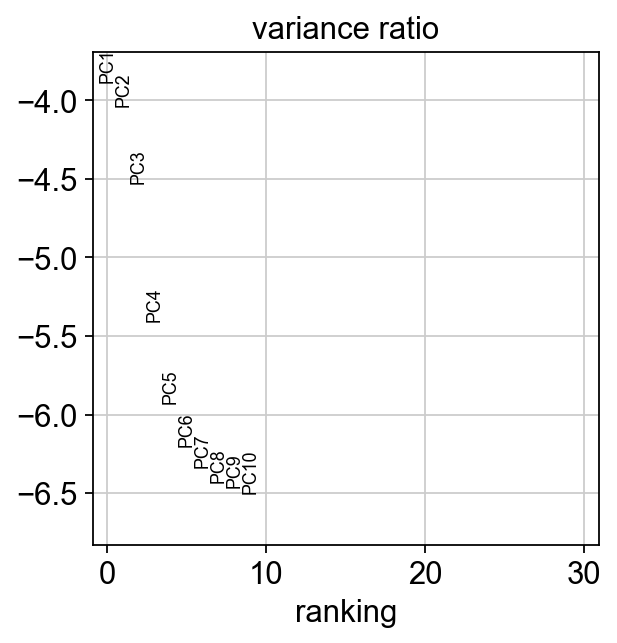

In [14]:
# run PCA then generate UMAP plots
sc.tl.pca(adata, svd_solver="arpack", n_comps=10, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

In [15]:
sc.pp.neighbors(adata, n_pcs=10, n_neighbors=20, use_rep="X_scVI")

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-pac

In [16]:
# neighbors were already computed using scVI

res = 0.01
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)
while not (adata.obs.leiden_scVI.values.categories.values).shape == (num_of_clusters,) or res == 1.0:
    res += 0.01
    sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)
print(adata)

AnnData object with n_obs × n_vars = 3934 × 3000
    obs: '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'leiden'
    obsm: 'X_scVI', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'


/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


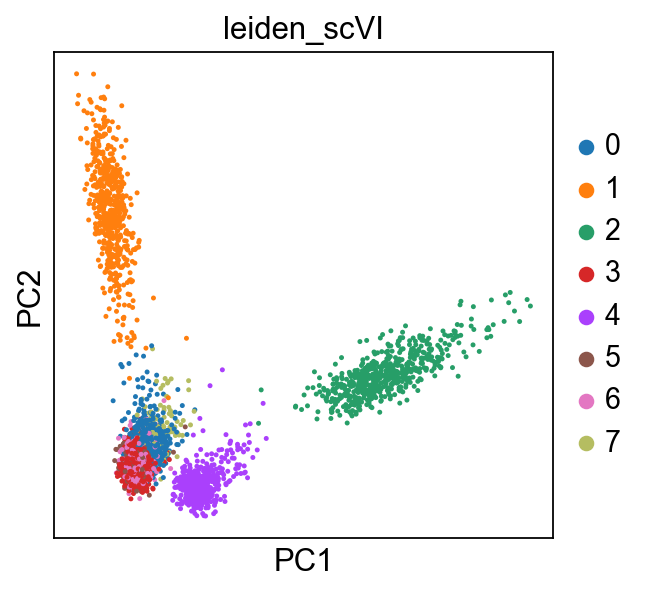

In [17]:
sc.pl.pca(
    adata,
    color=["leiden_scVI"],
    size=20,
)

In [18]:
sc.tl.rank_genes_groups(adata, 'leiden_scVI', method='wilcoxon') # method='wilcoxon' method='logreg'

In [20]:
df = pd.DataFrame(adata.obs['leiden_scVI'])

labels = df.rename(columns={'leiden_scVI': 'cluster'})
# rename index as cell
labels.index.names = ['cell']

labels['cluster'] = labels['cluster'].astype(int) + 1


labels.to_csv(save_path+'clustering_labels.csv')

In [49]:
number_of_genes = 50

de_df = model.differential_expression(
    groupby="leiden_scVI",
)
markers = {}
cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cell_type_df = de_df.loc[de_df.group1 == c]
    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 1]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]
    markers[c] = cell_type_df.sort_values('lfc_mean', ascending=False).index.tolist()[:number_of_genes]
    
df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(num_of_clusters):
    to_add = [ [markers[str(i)][j], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] += 1
df['rank'] += 1
df.to_csv(save_path+'markers.csv', index=False)

DE...: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


In [48]:
df

,gene,cluster,rank
0,RP11-403A21.2,1,1
1,TNFRSF4,1,2
2,CCL5,1,3
3,CISH,1,4
4,FUT7,1,5
...,...,...,...
395,MYC,8,46
396,PIM2,8,47
397,CCM2,8,48
398,CD52,8,49
